## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import StandardScaler  

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [3]:
raw_df = pd.read_csv('train_identity.csv')
trx_df = pd.read_csv('train_transaction.csv')

## Data pre-processing

In [4]:
training_df = pd.merge(trx_df, raw_df, on='TransactionID',how='left')


In [6]:
pd.DataFrame.to_csv(training_df,'training_df.csv') #just in case!

In [7]:
training_df.isnull().sum().sum()

115523073

In [33]:
columns_def=pd.DataFrame({"na_count":training_df.isnull().sum().sort_values(ascending=False)})
columns_def["per"]=columns_def["na_count"]/len(training_df)

In [9]:
range=[0.05, 0.10 ,0.15, 0.25, 0.40, 0.60, 0.75]


for num in range: 
    print (columns_def[columns_def["per"]<num].shape[0]/training_df.shape[1])


0.25806451612903225
0.25806451612903225
0.3686635944700461
0.41935483870967744
0.46543778801843316
0.5207373271889401
0.5207373271889401


In [10]:
limit=0.10
columns_final=columns_def[columns_def["per"]<limit].index 
training_df=training_df[training_df.columns.intersection(columns_final)]


In [11]:
# Categorical variables, must convert these to numbers
training_df[training_df.select_dtypes(include=['object']).columns].sample(10)

,ProductCD,card4,card6
41049,W,mastercard,debit
529679,W,visa,debit
280205,C,visa,credit
253163,W,visa,debit
103359,C,visa,debit
324157,W,visa,debit
235429,W,mastercard,debit
120575,H,visa,credit
39423,W,visa,debit
297915,C,mastercard,credit


In [81]:
col_list = []
for col in training_df:
    col_list.append(col)
print(col_list)

# for visuals
vis_df = training_df[['isFraud', 'TransactionDT', 'TransactionAmt','card1','card2','card3','card5','charge card', 'credit', 'debit', 'debit or credit','TransactionID']]



['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'charge card', 'credit', 'debit', 'debit or credit']


In [82]:
vis_df

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,charge card,credit,debit,debit or credit,TransactionID
1,0,86401,29.000,2755,404.0,150.0,102.0,0,1,0,0,2987001
2,0,86469,59.000,4663,490.0,150.0,166.0,0,0,1,0,2987002
3,0,86499,50.000,18132,567.0,150.0,117.0,0,0,1,0,2987003
4,0,86506,50.000,4497,514.0,150.0,102.0,0,1,0,0,2987004
5,0,86510,49.000,5937,555.0,150.0,226.0,0,0,1,0,2987005
...,...,...,...,...,...,...,...,...,...,...,...,...
590534,0,15811030,67.505,5812,408.0,185.0,224.0,0,0,1,0,3577534
590536,0,15811049,39.500,10444,225.0,150.0,224.0,0,0,1,0,3577536
590537,0,15811079,30.950,12037,595.0,150.0,224.0,0,0,1,0,3577537
590538,0,15811088,117.000,7826,481.0,150.0,224.0,0,0,1,0,3577538


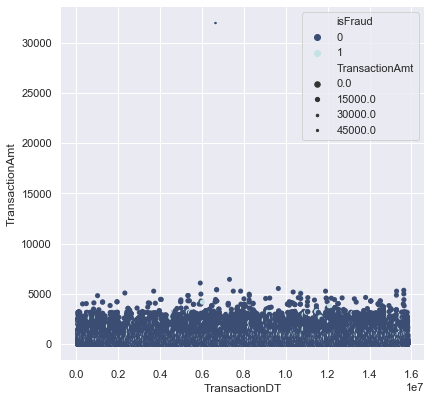

In [83]:
# Spot check for any starting points

sns.set(style="darkgrid")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="TransactionDT", y="TransactionAmt",
                hue="isFraud", size="TransactionAmt",
                palette="ch:r=-.2,d=.3_r",
#                 hue_order=clarity_ranking,
                sizes=(30, 5), linewidth=0,
                data=vis_df, ax=ax)

In [ ]:
vis_fraud_df = vis_df.loc[vis_df["isFraud"] == 1]

In [118]:
# numpy.arang(fraudcount)
fraudTransMin = vis_fraud_df["TransactionAmt"].min()
fraudTransMax = vis_fraud_df["TransactionAmt"].max()

In [ ]:
print(f'fraud transaction amounts\r\nmin:{fraudTransMin:>15.3f}\r\nmax:{fraudTransMax:>15.3f}')

fraudTransRange = np.arange(fraudTransMin,fraudTransMax)

frd_grps = np.array_split(fraudTransRange,10)

In [186]:
frd_grps[1].min().round()

frd_ranges = []

for i in frd_grps:
    frd_ranges.append(i.min())
    print(i.min())

0.292
520.292
1039.292
1558.292
2077.292
2596.292
3115.292
3634.292
4153.292
4672.292


520.0

In [113]:
fraudcount = vis_fraud_df.shape[0]



vis_fraud_df.loc[vis_fraud_df["TransactionAmt"] <600.0 ].shape[0]

19280

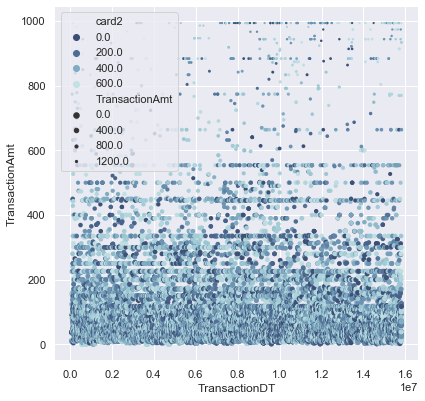

In [119]:
# see if there's any obvious patterns we can use to improve our model

sns.set(style="darkgrid")

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="TransactionDT", y="TransactionAmt",
                hue="card2", size="TransactionAmt",
                palette="ch:r=-.2,d=.3_r",
#                 hue_order=clarity_ranking,
                sizes=(30, 5), linewidth=0,
                data=vis_fraud_df.loc[vis_df["TransactionAmt"] <1000.0 ], ax=ax)

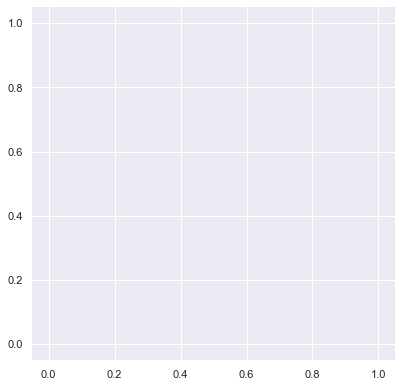

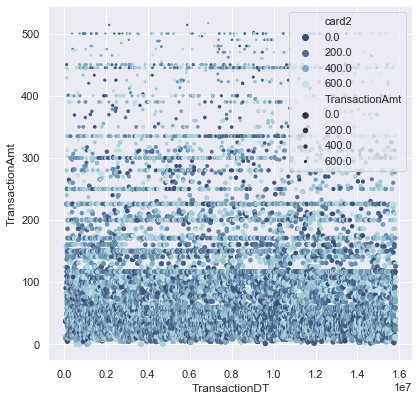

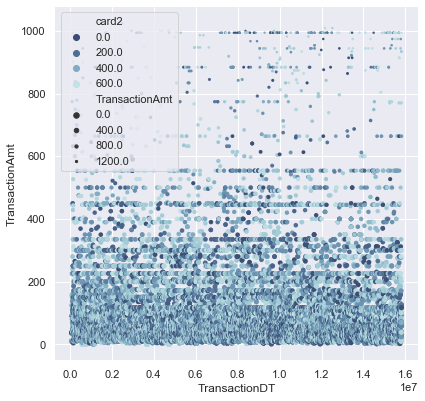

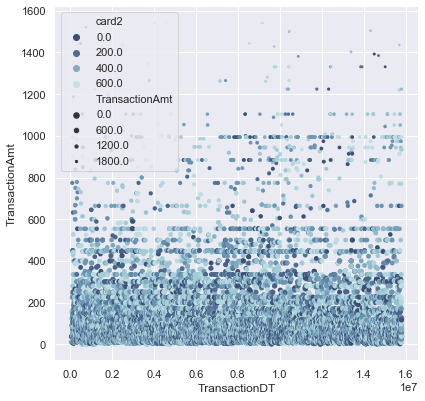

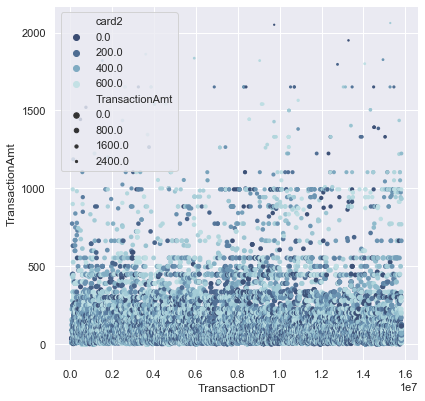

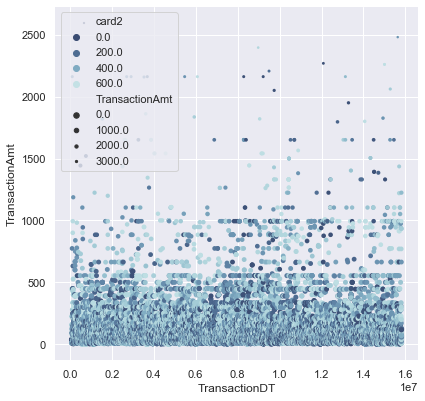

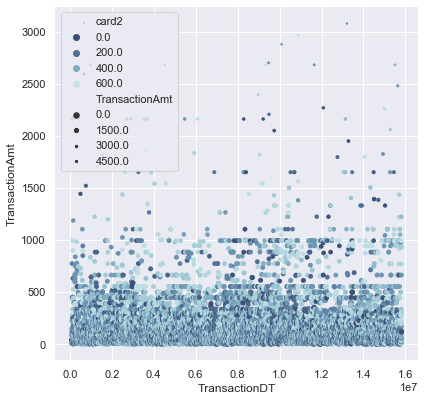

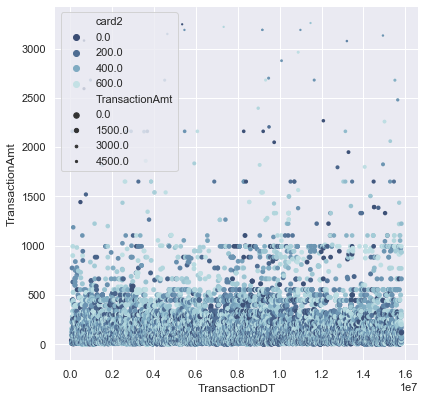

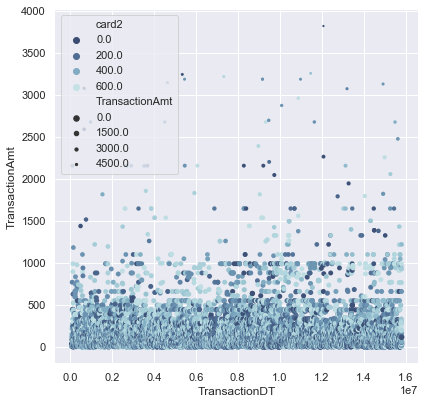

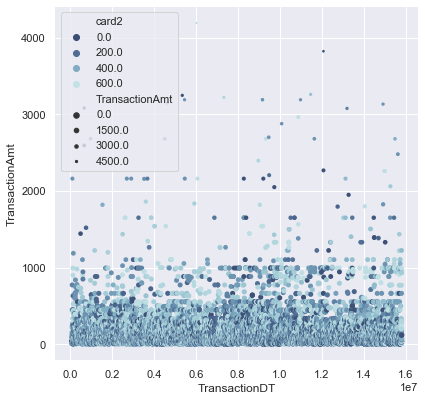

In [187]:
def plotThresholds(i):
    sns.set(style="darkgrid")

    f, ax = plt.subplots(figsize=(6.5, 6.5))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x="TransactionDT", y="TransactionAmt",
#                     hue="card",
                    size="TransactionAmt",
                    palette="ch:r=-.2,d=.3_r",
    #                 hue_order=clarity_ranking,
                    sizes=(30, 5), linewidth=0,
                    data=vis_fraud_df.loc[vis_df["TransactionAmt"] <i ], ax=ax)
for i in frd_ranges:
    plotThresholds(i)

No human readable patterns there! Onto the machine learning

In [12]:
# convert to numeric variables
card6_dummy_df = pd.get_dummies(training_df["card6"])
training_df = pd.concat([training_df,card6_dummy_df],axis=1)

In [13]:
# drop non-numeric data and na
training_df = training_df._get_numeric_data()
training_df = training_df.dropna()


In [14]:
print( f'isFraud sum: {training_df["isFraud"].sum():>10} \r\n totalRows : {len(training_df):>10}')
# print( f'percent diff: {len(training_df["isFraud"] == 1)/len(training_df):>10}') 

isFraud sum:      20018 
 totalRows :     578090


In [15]:
x_df=training_df.drop(["isFraud"],axis=1)
y_df=training_df["isFraud"]

In [16]:
X_train, X_test ,y_train ,y_test = train_test_split(x_df,y_df,test_size=0.50)

## Linear Regression Model

In [15]:
lr = LogisticRegression(solver='lbfgs')  
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
lr.score(X_test, y_test)

0.9653548755384109

In [17]:
y_pred=lr.predict(X_test)

In [18]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,All
True,,
0,279031,279031
1,10014,10014
All,289045,289045


In [19]:
recall_score(y_test, y_pred)

0.0

In [20]:
accuracy_score(y_test, y_pred)

0.9653548755384109